# _Kinetics of Reactions_ ( _Kinexns_ )

## 1. Building and solving the chemical kinetic model from chemkin input files

In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("/Users/prguser/Documents/kinexns/")

from kinexns.ode_builder import *
from kinexns.ode_solver import *
from kinexns.parse_chemkin import *

Could not find GLIMDA.


setting up the paths for the input files. Since these input files are not in chemkin format, they can be directly used with *kinexns*.

In [2]:
cwd = os.getcwd()

file_reactionlist, file_rateconstantlist, file_free_energy = set_paths(cwd)
file_rateconstantlist

'/Users/prguser/Documents/kinexns/Notebooks/example_xylose/data/complete_rateconstant_list.dat'

__What are these files? Lets Look at the reactionlist file first__

<img src = 'image/reaction.png' style = 'height:400px;width:600px'/> 



__Now the rate constant and free energy files__

<img src = 'image/rate.png' style = 'height:300px;width:250px'/> 
<img src = 'image/free.png' style = 'height:200px;width:600px'/> 

__Now, we have all the files in the required format__

Its time to create some additional variables required to build the model

In [3]:
# reac_prod_list = A list of reactants and products with their stoichiometric ratios
# speciesindices = a dictionary where the key is the species smiles and 
# value is the number to represent the species
# unique_species = a list of unique species present in the mechanism

reac_prod_list, speciesindices, unique_species = build_species_list(file_reactionlist)
first5species = {k: speciesindices[k] for k in list(speciesindices)[:5]}
first5species

# indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))


{'C(=O)=O': 0,
 'C=C(O)C=O': 1,
 'C=C(O)[C@@H](O)[C@H](O)C=O': 2,
 'C=O': 3,
 'CC(=O)/C=C(/O)C=O': 4}

__Create the stoichiometric matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species__

In [4]:
stoic_matrix = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
stoic_matrix

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8]])

__No Third body matrix required__

## Now build the rate constant values, both forward and reverse



In [5]:
# be sure to use the correct value of the variable convert. This varialble mentions the unit of the activation energy 
# listed in the rate constant file. The values of convert can be 'cal', 'kcal', 'KJ' and 'J' (the unit in the
# rate constant file)
temp = 773
forward_rate_constants_all = build_forward_rates(file_rateconstantlist, temp, convert='kcal')

__Since build_forward_rates fucntion returns both the forward rate constants and parameters, we need to collect the rate parameters in a seperate variable__

In [6]:
forward_rate_constants = forward_rate_constants_all[0]


__To include the reverse rate parameters and calculate them, we first need to calcualte the free energy of each species at the given temp__

In [7]:
thermo_dict = build_free_energy_dict(file_free_energy, temp)

__Next, if you want to include the reverse rate constants, calculate them using the function build_reverse_rates__

In [8]:
# The value 1 correspondce the converstion factor of the unit of energy in thermo_dict to Joule/mol.
# Since our free energies are calcualted directly from Gaussian, they are in hartrees. 
# So, we need to set the value of the factor carefully.

factor = 2625.5 * 1000

reverse_rate_constants = build_reverse_rates( thermo_dict, unique_species,stoic_matrix, factor,
                                             forward_rate_constants,temp, chemkin=False)
reverse_rate_constants

# If you do not want to include reverse rates in your calcualation just initiate them with zero
# reverse_rate_constants = np.zeros (len(forward_rate_constants))

[-3.95538139e+04 -6.67824018e+04 -6.46713160e+04  6.39605931e+03
  1.48020702e+04 -3.93713416e+04 -8.59817381e+04 -5.41311150e+04
 -5.63827963e+04  1.00546936e+04 -4.30840349e+04 -6.21059137e+04
 -7.26189670e+04 -5.02363170e+04 -7.54174087e+04 -7.74649049e+04
 -3.70974748e+04 -1.50210894e+04 -5.64602748e+04 -6.25459738e+04
 -8.66387170e+04 -1.16119301e+04 -8.15002984e+04 -1.33900500e+01
 -6.45466573e+04 -7.15094833e+04 -1.43448840e+05 -6.79424264e+04
 -3.56133059e+04 -8.01613459e+04 -8.20628905e+04 -3.20507387e+04
 -5.39011999e+04  1.19623819e+04 -9.47590997e+04 -1.14485715e+04
 -7.54107137e+04 -7.30823678e+04 -9.49324614e+04 -4.18893537e+04
 -4.48966539e+04 -4.28586095e+04  2.40670266e+06  2.43393125e+06
  2.42387655e+06  2.46696059e+06  2.46696059e+06  2.42529944e+06
  2.42172375e+06  2.47818402e+06  2.45638943e+06  2.41701809e+06
  2.42869521e+06  2.46430852e+06  2.44281568e+06  2.47486642e+06
  2.45551189e+06  2.46696046e+06  2.48820296e+06  2.48416756e+06
  2.56482274e+06  2.49680

[5.1545302447299276e-05,
 7.45041086207459e-07,
 3.377084903002129e-07,
 4.174337399515723,
 8.321889869181138,
 0.0012800290122825836,
 4.050623772519925e-07,
 4.406523419391018e-05,
 3.757921572090489e-06,
 3.9756810232043183,
 0.0007183391114416159,
 1.2740550991537638e-05,
 3.239883093643781e-06,
 9.779224388648916e-06,
 4.69199771628287e-06,
 1.413499119194173e-07,
 0.0018233895206496776,
 0.08033066992857188,
 8.96214378375536e-05,
 1.7946336293001957e-05,
 2.801242167604122e-07,
 0.09618332992148373,
 2.462071150067344e-08,
 0.5846378552382623,
 8.714683994471302e-06,
 7.255339875678166e-05,
 6.8031670674601884e-12,
 5.137808597176053e-06,
 0.002297069770939857,
 1.0019425652646004e-06,
 5.709109206121779e-07,
 0.003998706345963974,
 5.962218877570123e-05,
 2.461462359939088,
 7.917804018170257e-08,
 0.09865951787558633,
 2.0983274460498226e-06,
 3.0144938595014943e-06,
 1.540413848415e-07,
 0.00044655505029435165,
 0.00024204848340183,
 0.0004859483715401713,
 0,
 0,
 0,
 0,
 0

__Setting up the initial Condition__

In [9]:
y0 = np.zeros((len(unique_species)), dtype = float)
y0[speciesindices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']] = 1


__Now it is all set to solve the model__

In [22]:
mod, sim = stiff_ode_solver(stoic_matrix, y0, forward_rate_constants, reverse_rate_constants, third_body = None, sim_time = 10)

Final Run Statistics: --- 

 Number of steps                                 : 236
 Number of function evaluations                  : 264
 Number of Jacobian evaluations                  : 5
 Number of function eval. due to Jacobian eval.  : 230
 Number of error test failures                   : 2
 Number of nonlinear iterations                  : 260
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.05003202799991868 seconds.


__You can now calculate the mol/mass fraction of each species with time using the following function__

In [23]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def generate_mol_mass_fraction(array, species_dict, fraction):
    
    mol_wt = np.zeros((len(species_dict)), dtype = float)

    for i, mol in enumerate(species_dict):
        mol_wt[i] = Descriptors.MolWt(Chem.MolFromSmiles(mol))
    
    if fraction == 'mass':
        mass = array * mol_wt
        frac = mass / mass[1].sum()
    if fraction == 'mol':
        frac = array / array.sum(axis = 1, dtype = float)[:,None]
    
    return frac

mole_frac = generate_mol_mass_fraction(sim, speciesindices, 'mass')


RDKit WARNING: [10:14:03] WARNING: not removing hydrogen atom without neighbors


Text(0, 0.5, 'Mass Fraction (%)')

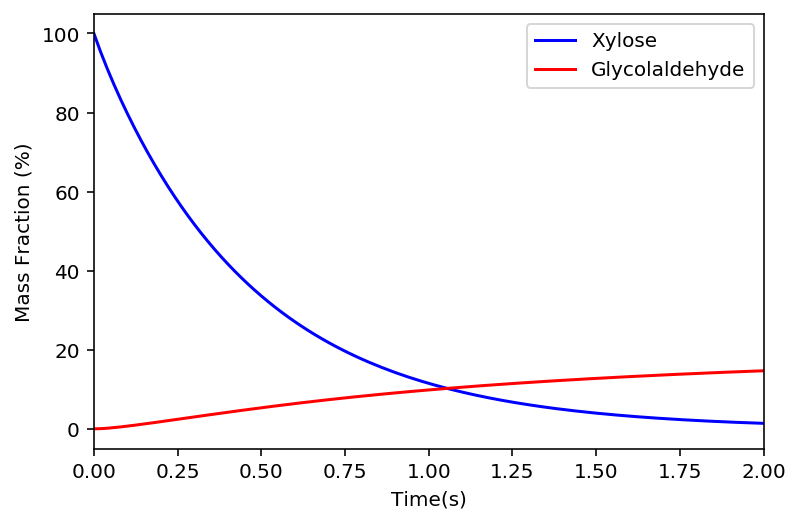

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(mod, mole_frac[:,speciesindices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']] * 100, color="b" , label = 'Xylose')
plt.plot(mod, mole_frac[:,speciesindices['O=CCO']] * 100, color="r" , label = 'Glycolaldehyde')
# plt.plot(mod, mole_frac[:,speciesindices['O=O']] * 100, color="r" , label = 'O2')
# plt.plot(mod, mole_frac[:,speciesindices['O']] *100, color="g" , label = 'O2')

#plt.ylim(0,100)
plt.xlim(0,2)
plt.legend()
# plt.xlabel('Time(s)')

plt.xlabel('Time(s)')
plt.ylabel('Mass Fraction (%)')
#plt.yscale('log')

## Sensitivity Analysis



- Here, we used SALib to perform SA
- The Saltelli sampler generates N*(2D+2) samples, where in is the number of samples, and D the number of model inputs. The keyword argument __calc_second_order=False__ will exclude second-order indices, resulting in a smaller sample matrix with 𝑁 * (𝐷 + 2) rows instead.
- We need to supply a list of parameters and their upper and lower bounds to vary in an input file. In the example input file, all the rate parameters are varied one order of magnitude above and below their prescribed value, but the range was written as 1 and -1.
- we also need to supply the name of the output files where generated parameter combinations are written.

__Setting the path__

In [13]:
#generate parameters for SA

setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data_parallel/'


__Importing the module and generating parameter sets__

In [17]:
from kinexns.sensitivity_analysis import *
gen_params(1000, setpath,'params.txt','param_set.txt')

__Defining the file names__

In [14]:
import io
cwd = os.getcwd()
file_path_read = setpath + 'param_set.txt'
file_path_write = setpath +'model_solutions.txt'
file_input = setpath + 'params.txt'


__Importing the parallel solver__

In [15]:
from kinexns.parallel_solver import *

__Solve the the various parameter sets using multiprocessing__

In [ ]:
#multisolve(4, file_path_read, file_path_write, forward_rate_constants, file_rateconstantlist, file_free_energy, stoic_matrix, unique_species, 'kcal', y0, 10, chemkin=False)

__Analyze sensitivity on a specific model output__

In [18]:
analyze_sensitivity(setpath, speciesindices['O=CCO'], "\'\t'", 2,'glycolaldehyde', parallel=True)

__Plot SA results for top n sensitive parameters__

['analysis_furfural.txt', 'analysis_glycolaldehyde.txt']


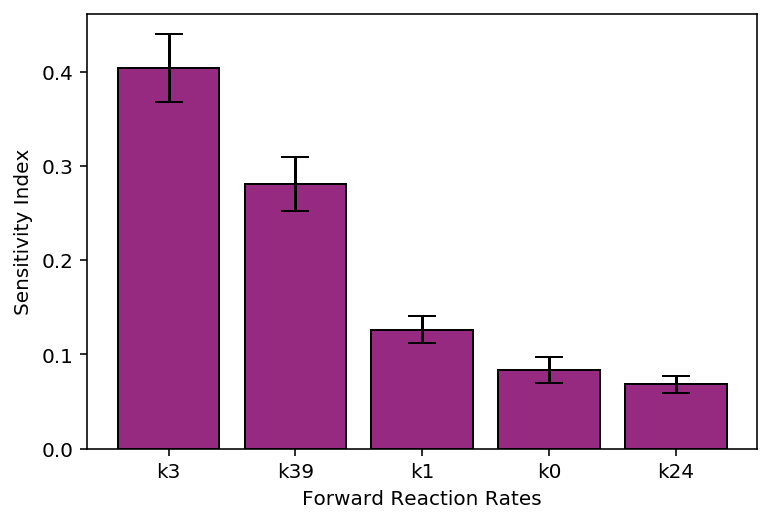

In [19]:
plot_sensitivity_results(setpath, 'glycolaldehyde', number=5)

In [20]:
draw_top_reactions(setpath, 'glycolaldehyde', reac_prod_list)

['analysis_furfural.txt', 'analysis_glycolaldehyde.txt']
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 

In [ ]:
# import aggdraw
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mol = 'C1=CC=CC=C[C+]1'
mol = Chem.MolFromSmiles(mol)
Draw.MolToImage(mol)


<img src = 'image/sensitive_reactions_glycolaldehyde.png' style = 'height:400px;width:300px'/> 